In [5]:
from IPython.display import Image

# Вступление

Основная цель данного проекта создать __единую аналитическую систему__, которая будет решать несколько вопросов:
1. автоматизированный ответ на 80% (принцип Парето) возникающих вопросов, как внутренних, так и внешних
2. поиск ошибок в данных (например, income type в векторе одобрения) - Мономах
3. проверка логики расчета ключевых показателей (например, лимитная логика)
4. отслеживание измений ключевых показателей (approval rate, default rate) в различных сегментах - эволюция Мономаха
5. статистический модуль для запуска и анализа эффективности пилотов
6. систематизированный подход к построению отчетности

Задача объемна, следовательно, необходимо задать принципы деления всего объема данных и метрик по категориям, в рамках которых будут строиться отчеты или иные аналитические инструменты:
1. <font color=blue> клиентский путь, а именно его точки взаимодействия с банком, в которых присутствует блок рисков </font>
    1. оформления заявки
    2. получение повторного предложения
    3. специфические для карты
        1. изменение лимита по карте
        2. изменение продукта по карте
        3. перевыпуск карты
    4. специфические для кеша
2. рисковые метрики
    * ранние индикаторы (default rates, @3-30)
    * балансовые винтажи по поколениям
    * портфельные метрики (NPL, cure rate)
    * CRE

Подпункты А-D в <font color=blue> синем пункте </font> представляют из себя отдельные большие блоки аналитики, рассмотренный ниже

# Оформление заявки

## 1. Пролог

Поскольку это первый раздел, который описывается, здесь уместно рассказать про принципы, которые будут использоваться при описании каждого раздела:
1. дается краткое описание стадии в подразделе "пролог", зачем стадия вообще нужна, как взаимодействует с другими этапами жизненного цикла, где и какая в этом всем роль рисков. 
2. вводятся ключевые метрики, которые используются в рамках данного раздела. Эти метрики описывают эффективность всего процесса целиком, а не только его рисковой составляющей.
3. описываются несколько уровней отчетности от верхнего до наиболее детального.
4. рассматриваются другие аналитические инструменты, используемые для решения различных задач, возникающих на данной стадии.

Итак, первый раздел, оформление заявки, - то, с чего все начинается для клиента. Роль рисков тут очевидна, они решают кому стоит одобрить кредит, а кому нет. Основной процент потерь клиентов на этой стадии также проиходит в процессе одобрения.

Подразумевается, что на момент написание данного текста (27.04.2021) основной и единственный процесс банка по офорлению заявки - это процесс 5-полей.

## 2. Основные метрики

Все метрики в каждом разделе делятся на 2 большие группы:
* измеряющие в процентах (*relative value metrics, RVM*), каждый такой показатель в своем названии содержит слово rate, кроме некоторых устоявшихся исключений
* измеряющиеся в абсолютных значениях (*absolute value metrics, AVM*)

Очевидно, что ключевых для банка метрик в процессе оформления заявки две:
1. количество выданных кредитов, __amount of contracts__ (_AVM-метрика_)
2. следствие из п1 - конверсия, __conversion rate__, отношение выданные кредитов к оформленным заявкам (_RVM-метрика_)

Для того, чтобы наиболее полно описать и детализировать метрики из п1 и п2, а также выделить роль рисков в процессе, вводится несколько дополнительных метрик.

### 2.1. AVM

1. Amount of applications - количество заявок, которые оформили клиенты за определенный промежуток времени.
2. Amount of contracts - количество контрактов, выданное банком из оформленных в п1 заявок.
3. Sum limits - сумма открытых лимитов по картам или сумма выданных кредитов по ПОС или кэш (более важный в случае последних показатель).

### 2.2. RVM

1. Click-through rate: $CTR =\frac{Click}{ShownBanner}$, только для онлайна. Важный показатель, который рассчитывает долю кликов от количества показов объявления, например, в контекстной рекламе поисковой выдачи
2. Approval rate: $AR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{Loss_i}$, Здесь нужно остановиться поподробнее:
    1. изначально уровень одобрения рассматривался, как доля одобренных заявок из всего входного потока. В формуле выше этот принцип сохранен
    2. нюанс в том, что в процессе оформления (5-полей) есть несколько точек, когда управление передается на фронт-систему и клиенту необходимо выполнить действие, например, выбрать оффер или заполнить 2-ой блок данных
    3. если клиент не захочет выполнять действие из п2, заявка аннулируется, при этом ни одобрения, ни отказа в итоге не произойдет
    4. такие случаи надо обрабатывать, это делается с помощью механизма потерь
3. $\prod_{i=1}^{n}\frac{1}{Loss_i}$ - точки в процессе, где клиенту нужно совершить какое-то действие (например, выбрать оффер), $Loss_i$, доля клиентов, которая это действие совершила. На текущий момент таких точек в процессе 3: 
    1. NMD rate: $NMDR = \frac{PassedNMD}{SentToNMD}$, часть клиентов отправляется на процесс заполение 2-го блока данных до скоринга, этот процесс называется Need More Data
    2. Take up rate: $ TUR = \frac{PassedOffer}{SentToOffer}$, каждый клиент попадает на этап выбора предложения, где он может как определиться с итоговым продуктом, так и выбрать лимит
    3. Need photo rate: $NPHR = \frac{PassedNeedPhoto}{SentToNeedPhoto}$, часть клиентов, которые оформляют заявки в "удаленных" каналах, то есть без фактического присутствия в офисе, отправляются в офис, чтобы сфотографироваться и подтвердить свою личность
4. Sign rate: $SR = \frac{Signed}{Approved}$, доля подписанных из одобренных
5. Conversion rate: $ CR = \frac{Signed}{IncomingFlow} = AR * LOSSES * SR$, конверсия - это отношение выданных кредитов к входящему потоку, может быть выражена через произведение промежуточных RVM метрик

NB: формулы AR и CR будут более подробно рассмотрены ниже и уточнены

#### 2.2.1. AR

Поскольку в разделе RVM нет строгого доказательства формулы $AR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{Loss_i}$, оно дается ниже и также описывается несколько типов уровня одобрения, которые будут использоваться в отчетности

__Доказательство $AR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{Loss_i}$__

Для понимания формулы рассмотрим конкретный пример:
Пусть в упрощенном процессе одобрения есть только отказ до оффера, выбор оффера и отказ после выбора оффера и из 100 заявок до выбора оффера дошло 50, оффер выбрало 40, из которых до финального одоберения дошло 30, чему же равен AR в данном случае?

Пользуясь формулой $AR = \frac{Approved}{IncomingFlow}$ получаем 30%, но при этом никак не учитывается факт того, что 10 заявок потерялись на выборе оффера и никакого отказа по ним не было

Напрашивается логичный вывод, давайте рассматривать процесс отдельно до оффера и после. Изначально было 100 заявок, из них одобрилось только 50, следовательно, $AR_{beforeOffer} = \frac{50}{100} = 50\%$

После выбора оффера осталось только 40 заявок, из которых осталось только 30, следовательно $AR_{afterOffer} = \frac{30}{40} = 75\%$

Для получения финального одобрения необходимо перемножить эти 2 величины $ AR = AR_{beforeOffer} * AR_{afterOffer} = 50\% * 75\% = 37,5\%$

Выводы:
1. согласимся с тем, что 37,5% и 30% - это не одно и тоже
2. количество стадий могло бы быть и больше, например, $stage1, stage2, ..., stageN$, AR в этом случаем вычислялся бы как $ AR = AR_{stage1} * AR_{stage2} * ... * AR_{stageN}$ или $AR = \prod_{I=1}^{N}AR_{stageI}$ и на этом можно было бы и закончить, но в этом случае теряется связь с изначальной формулой $AR = \frac{Approved}{IncomingFlow}$
3. если расписать подробно формулу выше $AR = AR_{stage1} * AR_{stage2} *AR_{stage3} * ... * AR_{stageN} = \frac{ApprovedStage_1}{IncomingFlow}*\frac{ApprovedStage_2}{AfterLoss_1} *\frac{ApprovedStage_3}{AfterLoss_2} * ... * \frac{Approved}{AfterLoss_{N-1}}$, сомножители в формуле можно перегруппировать так: все числители дробей $ApprovedStage1, ..., ApprovedStageN-1, Approved$ сдвинуть на 1 дробь вправо, при этом $Approved$ перейдет в первую дробь
4. получится дробь $AR = \frac{Approved}{IncomingFlow}*\frac{ApprovedStage_1}{AfterLoss_1} *\frac{ApprovedStage_2}{AfterLoss_2} * ... * \frac{ApprovedStage_{N-1}}{AfterLoss_{N-1}}$
5. первый сомножитель - изначальное определение $AR$, все остальные вида $\frac{ApprovedStage_i}{AfterLoss_i}$ не что иное, как обратная величина "потери" клиентов $\frac{1}{Loss_i}$ после $i-ой$ стадии одобрения
6. в итоге мы получаем искомую формулу: $AR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{Loss_i}$. Здесь $Loss_i$ назван так из-за потери для процесса одобрения. При этом формула  $Loss_i= \frac{AfterLoss_i}{ApprovedStage_i}$  говорит о том, какая доля людей прошла ту или иную стадию фронта, например, выбрала оффер

__Проблематика $\prod_{i=1}^{n} \frac{1}{Loss_i}$, формула для $Loss_i$__

Но и это еще не все, проблема заключается в том, что потеря $Loss_i = \frac{AfterLoss_i}{ApprovedStage_i}$ не учитывает факт того, что не на каждую стадию фронта $i$ идут все клиенты из $ApprovedStage_i$. 

На текущий момент стадий фронта в процессе 3, соответствующие метрики потерь определены в пункте RVM, как:
1. NMD rate: $NMDR = \frac{PassedNMD}{SentToNMD}$
2. Take up rate: $ TUR = \frac{PassedOffer}{SentToOffer}$
3. Need photo rate: $NPHR = \frac{PassedNeedPhoto}{SentToNeedPhoto}$

и, если на выбор оффера п2 идут все заявки, то есть $ApprovedPreviousStage = SentToOffer$, то на NMD и Need photo идут далеко не все. Следовательно, для этих стадий $SentToStageName <> ApprovedPreviousStage$

Как же быть? Есть 2 потенциальных решения:
1. мерить всегда уровень потерь, как $Loss_i = \frac{AfterLoss_i}{ApprovedStage_i}$
    1. плюсов в подходе 2:это просто и конверсия будет вычисляться, как произведение всех метрик
    2. минус в том что, чем меньше доля отправки на стадию, тем больше дробь $\frac{AfterLoss_i}{ApprovedStage_i} \rightarrow  1$. При том, что само отношение прошедших стадию к отправленным может быть и мало

Здесь перед п2 приведем пример,из которого будет понятен тезис B из п1, а также то, что происходит в п2

Рассмотрим процесс NMD. Предположим до выбора идти или нет на NMD дошло $50$ клиентов, $30$ не пошло на NMD, а $20$ пошло. Из $20$ отправленных на NMD $3$ не заполнили 2 блок, $17$ заполнили.

Рассчитаем значения, $AfterLoss = 50 - 3 = 47, ApprovedPreviousStage = 50, Loss = \frac{47}{50} = 94\%$. Но ведь на самом деле количество клиентов, которые были отправлены на NMD всего $20$, и прошли из них $17$, значит $NMDR$ из RVM определяется, как $ NMDR = \frac{17}{20} = 85\%$, что существенно ниже $94\%$. Если доля отправления на NMD будет уменьшаться, не 20 из 50, а, например, 10 из 50, разница между $Loss$ и $NMDR$ будет только увеличиваться, а $Loss$ будет стремиться к 1 при уменьшении доли отправки на NMD.

Понятно также,  что $Loss$ не может быть меньше доли не отправленных на проверку. Если отправка всего 10%, $Loss >= 90\%$, хотя сам $NMDR$ может быть при этом сколь угодно мал.

2. итак, минус проиллюстрирован, распишем формулу $Loss_i = \frac{AfterLoss_i}{ApprovedStagei}$ подробнее.
    1. для начала сделаем замену переменных для упрощения записи: $AfterLoss_i = AL_i, ApprovedStage_i = AS_i$, тогда $Loss_i = \frac{AL_i}{AS_i}$ 
    2. пусть также количество клиентов из $AS_i$, пошедших на фронт, равна $A_i$, соответствующая доля (потенциальная потеря) $p_i = \frac{A_i}{AS_i}$, а количество клиентов, которые потерялись $L_i$ 
    3. изначальная формула может быть записана так: $Loss_i = \frac{AL_i}{AS_i} = \frac{AS_i - L_i}{AS_i}$
    4. понятно, что потеря $L_i$ может получиться только из заявок, которые отправились на фронт $A_i$, тогда кажется логичным, что формула для $Loss_i$ может быть переписана, как $Loss_i = p_i * \frac{A_i - L_i}{A_i} + (1 - p_i)$. Т.е. доля заявок, отправленных на фронт умножить на вероятность пройти стадию + заявки, которые туда не пошли
    5. докажем, эквивалентность формул из с п. С и D
    6. распишем по определениям формулу из п. E: $Loss_i = p_i * \frac{A_i - L_i}{A_i} + (1 - p_i) = \frac{A_i}{AS_i} * \frac{A_i - L_i}{A_i} + 1 - \frac{A_i}{AS_i}$, сокращаем на $A_i$, приводим все слагаемые к общему знаменателю и получаем $\frac{A_i - L_i + AS_i - A_i}{AS_i} = \frac{AS_i - L_i}{AS_i}$
    7. эквивалентность C и D доказана, значит $Loss_i = p_i * \frac{A_i - L_i}{A_i} + (1 - p_i)$, где $\frac{A_i - L_i}{A_i}$ - это не что иное, как $\frac{PassedFront}{SentToFront}$, то есть любая метрика потерь на фронте из VMR, например, $NMD$
    8. обозначим через $LostOnFront_i = LoF_i = \frac{A_i - L_i}{A_i}$, тогда итоговая формула одобрения запишется, как $AR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{p_i * LoF_i + (1 - p_i)}$

__Ключевая формула: $AR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{p_i * LoF_i + (1 - p_i)}$, где $p_i = \frac{SendedToFront}{ApprovedPreviousStage}$, а $LoF_i = \frac{passedFront_i}{SentToFront_i}$__

__Виды AR__

В силу того, что в банке используется процесс __мультиподбора__, когда клиенту может одобриться не основной продукт (например, кеш, когда он приходил за картой) или сразу несколько видов одного продукта (например, карта Свобода и карта Польза), в разных ситуацциях может понадобиться считать разный AR:
1. <font color=red> на клиента </font>
2. <font color=orange> на тип контракта (везде в отчетности, если фильтр относится к продукту - название_с)</font>
3. <font color=green> на продукт (везде в отчетности, если фильтр относится к продукту - название_p)</font>

Каждый из них определен немного по разному, одна и та же заявка для одного вида AR считается одобренной или отказанной, для другого аннулированной, а для 3-го вообще не браться в расчет. Рассмотрим все подробно на примере. 

Клиент пришел оформлять заявку на <font color=blue>карту</font> (_sk_contract_type_priority_ = $3$), на точке подключены продукты: <font color=brown>кеш</font>, <font color=blue>карта Польза</font> и <font color=blue>карта Свобода</font>. <font color=brown>Кеш</font> отказался на скоринге, при этом по обеим <font color=blue>картам</font> вернулось предложение с лимитом по 50к, клиент выбрал <font color=blue>карту Польза</font> и одобрился на полной заявке. Вопрос, как эта заявка учитывается в различных одобрениях?
1. <font color=red> на клиента</font>: в одобрении на клиента <font color=red>рассматриваются все заявки, заведенные на любой продукт</font> (_sk_contract_type_priority_ __не имеет значения__). Если <font color=red>одобряется любой продукт</font>, заявка считается <font color=red>одобренной</font>. В примере выше одобрилась карта на 50к, значит заявка считается одобренной. Если бы заявка была заведена на кеш и одобрилась карта, ничего бы не поменялось, заявка по прежнему считалась бы одобренной
2. <font color=orange> на тип контракта</font>: в одобрении на тип контакта рассматриваются <font color=orange>только</font> заявки, которые изначально пришли <font color=orange>на этот тип контракта</font>. Одобренной считается заявка, в которой одобрен <font color=orange> тот же тип контракта </font>. В примере: 
    1. <font color=orange>в одобрении</font> на <font color=blue>карту</font> данная заявка <font color=orange>рассматривается</font> и она <font color=orange>одобрена</font>
    2. <font color=orange>в одобрении</font> на <font color=brown>кеш</font> данная заявка <font color=orange>не рассматривается </font>
    3. если бы _sk_contract_type_priority_ был $2$, а не $3$, заявка бы <font color=orange>рассматривалась</font> на <font color=brown>кеш</font> и была <font color=orange>отказана</font>, на <font color=blue>карту</font> заявка бы <font color=orange>не рассматривалась</font>. Данное одобрение учитывалось бы только в одобрении <font color=red>на клиента</font>
3. <font color=green>на продукт</font>: в одобрении на продукт рассматриваются <font color=green>только заявки</font>, которые пришли <font color=green>изначально на нужный тип контракта __И__ у них есть trial на нужный продукт</font>. Одобренной считается заявка, в которой одобрен <font color=green>тот же продукта</font>. В примере:
    1. <font color=green>заявка</font> на <font color=blue>Свободу</font> <font color=green>рассматривается</font> и она <font color=green>аннулирована</font>
    2. <font color=green>заявка</font> на <font color=blue>Пользу</font> <font color=green>рассматривается</font> и она <font color=green>одобрена</font>
    3. <font color=green>заявка</font> на <font color=browwn>кеш</font> <font color=green>не рассматривается</font>, так как <font color=green>не тот тип контракта</font>

#### 2.2.2. CR

$ CR = \frac{Signed}{IncomingFlow} = AR * LOSSES * SR$, формула через произведение также дается без какого-либо доказательства, а также объяснения того, зачем она вообще нужна, если это просто отношение $\frac{Signed}{IncomingFlow}$, зачем какие-то усложнения?

Дело в том, что выраженная через произведение других RVM-метрик, конверсия становится зависимой от них величиной и можно явно наблюдать, как изменение каждой из них влияет на итоговое значение самой важной метрики процесса, что удобно.

__Посмотрим, как выражается CR через произведение других RVM-метрик и выясним, что такое $LOSSES$__

Просто подставим значения метрик $AR$ и $SR$ в произведение:

$CR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{p_i * LoF_i + (1 - p_i)} * LOSSES * \frac{Signed}{Approved}$, сократим $Approved$, перенесем $Signed$ в первый сомножитель:

$CR = \frac{Signed}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{p_i * LoF_i + (1 - p_i)} * LOSSES$

Так как $CR = \frac{Signed}{IncomingFlow}$, следовательно, $LOSSES = \prod_{i=1}^{n} p_i * LoF_i + (1 - p_i)$, то есть в нашем случае:
$LOSSES = [p_{NMD} * NMDR + (1 - p_{NMD})] * [p_{offer} * TUR + (1 - p_{offer})] * [p_{photo} * NPHR + (1 - p_{photo})]$, или иными словами произведение всех потерь на фронте с соответствующими долями отправки.

RVM-метрики $NMDR$, $TUR$ и $NPHR$ будут всегда описываться парой значений: доля отправки на стадию и доля прошедших из отправленных  

## 3. Reports

Оптимайзер
Пилоты
Фантомас
ПДН

### 3.1. High level report

1. __Key financial metrics__
    1. <font color=green> inflation rate
    2. rate cap by Q
    3. avg deposit rate
    4. avg credit rate </font>
2. __Market analysis based on Frank research pdf__
    1. <font color=orange> balance graph
    2. transactions graph
    3. $\frac {BalanceDelta}{TransactionsAmount}$ </font>
3. __All metrics above in one report__
    1. <font color=red> compare to budget
    2. compare to previous week 
    3. compare to Arima prediction to this date (each parameter)</font>

### 3.2. Examples

* Main metrics
* Target
* Some dynamics also with target

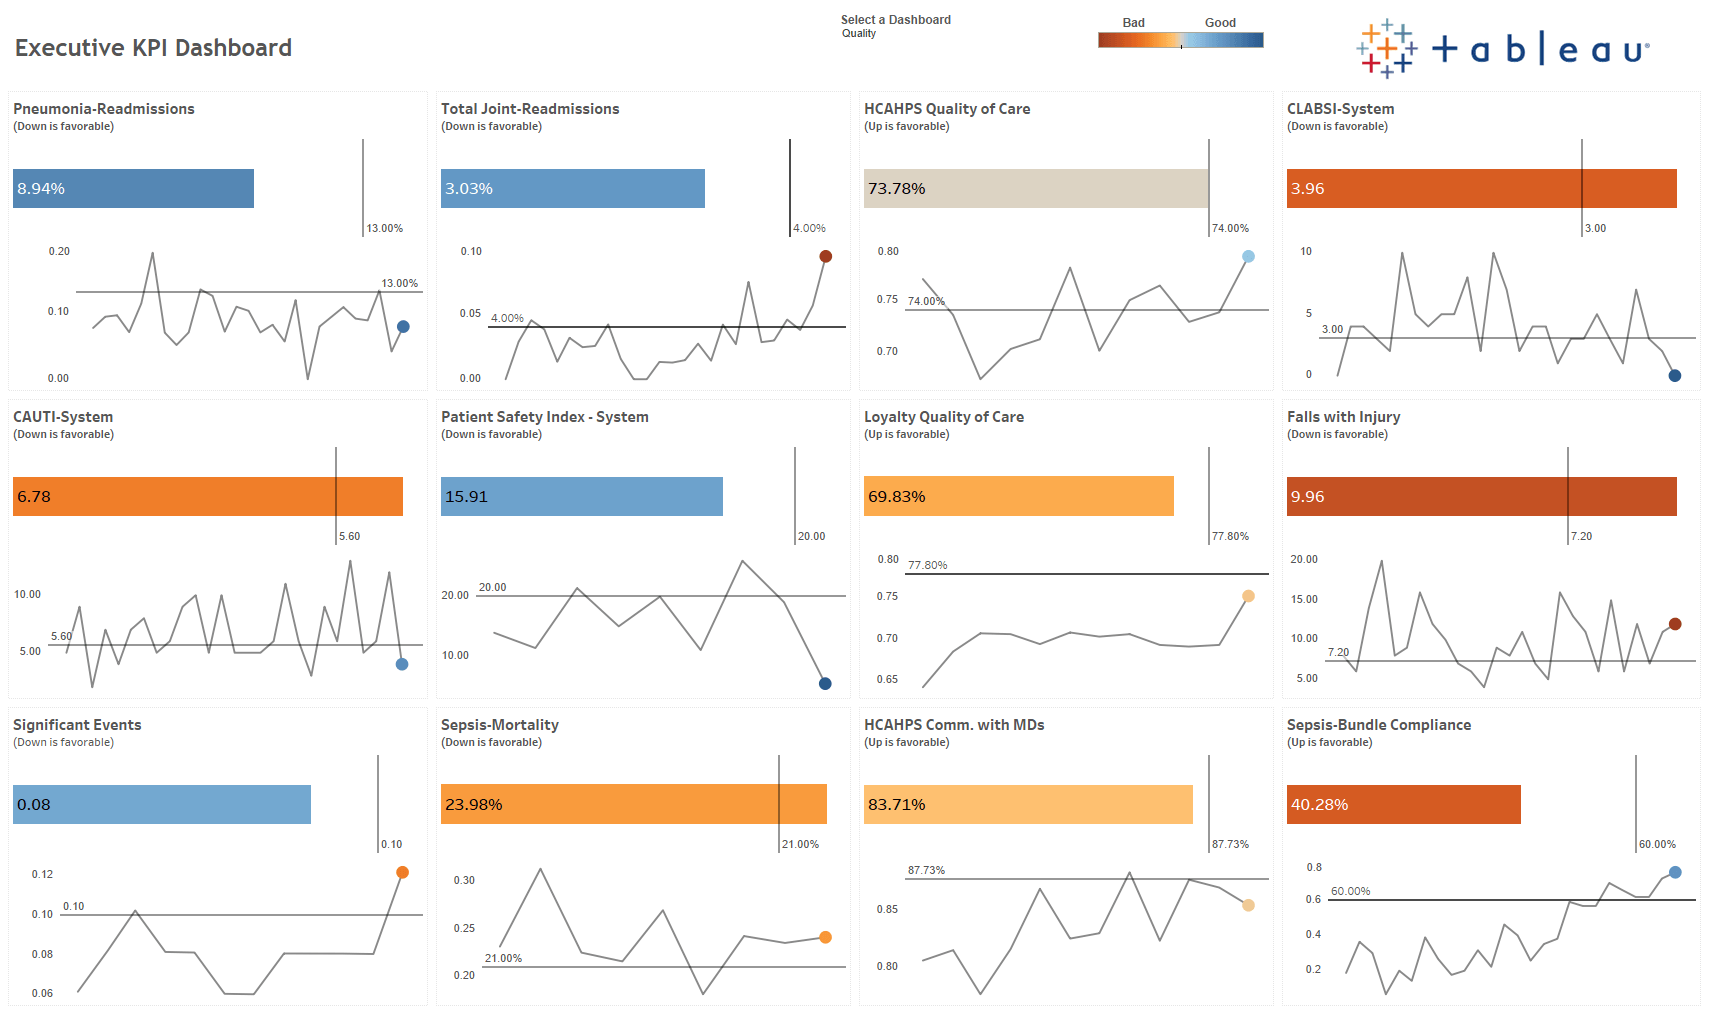

In [6]:
Image("HL_main_KPI_with_dynamics.png")

* Compare to previous time interval
* Dynamic
* All key metrics

### 3.2. Approval reports

Рассмотрим формулу $AR = \frac{Approved}{IncomingFlow} * \prod_{i=1}^{n} \frac{1}{Loss_i}$ детально


#### 3.2.1. Approval numbers report

#### 3.2.2. Main stages process reports

1. Hardcheck report
2. Scoring report
3. Limit logic report
4. UW report

1. data quality (DQ) of vector parameters (both, NA and distribution)
2. calc DWH logic, compare to blaze
3. key filters:
    * stage
    * trial
    * client type

1. DQ of vector
2. distribution incoming flow (IF) by score cards
3. distribution IF by score sets
4. cutoff registry
5. key filters
    * client type
    * channel

## 4. Key dimensions

1. Time window
2. Product
3. Channel
4. client type

### Репортинг стадий блейза

1. описать, что я имею ввиду под БП (бизнес правилами проверки)
2. каждая стадия имеет свое описание БП отказов и БП отправки на дальнейшие стадии (HC table and RG table)
3. процедура или пакет на PL/SQL или на Python, который реализует логику БП каждой стадии на DWH и сравнивает результаты с Blaze.
4. при заведении JRisk на Blaze, который изменяет БП какой-то стадии, меняется соответствующее описание на confluence и меняется процедура в DWH
5. при внедрении изменения проверяется процент расхождения на Blaze и БП. Заказчик задачи подтверждает, что такой уровень расхождений объясним и является приемлимым
6. формируется репортинг на Tableau с расхождениями на каждой стадии по каждому бизнес правилу
7. Маномах пытается отслеживать стат значимые различия между Blaze и БП на основании заданных параметров в п5

### Систематизация confluence

1. Сделать несколько навигационных страниц
    1. общая навигационная страница по разделам (approval process, score, limit, PDN, full approve, iptimizer, WIKI)
    2. в каждой отдельной теме также своя навигационная страница с темами, которые рассматриваются